# Flax ogbg-molpcba Example

<a href="https://colab.research.google.com/github/google/flax/blob/main/examples/ogbg_molcpba/ogbg_molcpba.ipynb" ><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Demonstration notebook for
https://github.com/google/flax/tree/main/examples/ogbg_molcpba.

## Setup

In [1]:
# Install clu, ml-collections, latest Flax version, and tensorflow_datasets.
!pip install -U -q git+https://github.com/google/CommonLoopUtils@7664744 ml-collections git+https://github.com/google/flax@62735e2 tfds_nightly jraph

     |████████████████████████████████| 88 kB 5.7 MB/s 
     |████████████████████████████████| 4.0 MB 60.0 MB/s 
     |████████████████████████████████| 73 kB 3.2 MB/s 
     |████████████████████████████████| 118 kB 69.4 MB/s 
     |████████████████████████████████| 57 kB 7.9 MB/s 


In [2]:
example_directory = 'examples/ogbg_molpcba'
editor_relpaths = ('configs/default.py', 'input_pipeline.py', 'models.py', 'train.py')

repo, branch = 'https://github.com/google/flax', 'test_388530186'

In [3]:
# (If you run this code in Jupyter[lab], then you're already in the
#  example directory and nothing needs to be done.)

#@markdown **Fetch newest Flax version and copy of example code.**
#@markdown
#@markdown **If you select no** below, then the files will be stored on the
#@markdown *ephemeral* Colab VM. **After some time of inactivity, this VM will
#@markdown be restarted and any changes will be lost**.
#@markdown
#@markdown **If you select yes** below, then you will be asked for your
#@markdown credentials to mount your personal Google Drive. In this case, all
#@markdown changes you make will *persist*. Even if you re-run this
#@markdown Colab notebook later on, the files will still exist. You can
#@markdown remove directories inside your Drive's `flax/` root if you want to
#@markdown manually revert these files.

if 'google.colab' in str(get_ipython()):
  import os
  os.chdir('/content')
  # Download Flax repo from Github.
  if not os.path.isdir('flaxrepo'):
    !git clone --depth=1 -b $branch $repo flaxrepo
  # Copy example files & change directory.
  mount_gdrive = 'no' #@param ['yes', 'no']
  if mount_gdrive == 'yes':
    DISCLAIMER = 'Note : Editing in your Google Drive, changes will persist.'
    from google.colab import drive
    drive.mount('/content/gdrive')
    example_root_path = f'/content/gdrive/My Drive/flax/{example_directory}'
  else:
    DISCLAIMER = 'WARNING : Editing in VM - changes lost after reboot!!'
    example_root_path = f'/content/{example_directory}'
    from IPython import display
    display.display(display.HTML(
        f'<h1 style="color:red;" class="blink">{DISCLAIMER}</h1>'))
  if not os.path.isdir(example_root_path):
    os.makedirs(example_root_path)
    !cp -r flaxrepo/$example_directory/* "$example_root_path"
  os.chdir(example_root_path)
  from google.colab import files
  for relpath in editor_relpaths:
    s = open(f'{example_root_path}/{relpath}').read()
    open(f'{example_root_path}/{relpath}', 'w').write(
        f'## {DISCLAIMER}\n' + '#' * (len(DISCLAIMER) + 3) + '\n\n' + s)
    files.view(f'{example_root_path}/{relpath}')

Cloning into 'flaxrepo'...
remote: Enumerating objects: 349, done.
remote: Counting objects: 100% (349/349), done.
remote: Compressing objects: 100% (306/306), done.
remote: Total 349 (delta 68), reused 145 (delta 25), pack-reused 0
Receiving objects: 100% (349/349), 1.80 MiB | 19.41 MiB/s, done.
Resolving deltas: 100% (68/68), done.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
# Display current working directory.
# Note: In Colab, running the above cell changes the working directory.
!pwd

/content/examples/ogbg_molpcba


## Imports

In [5]:
# Base imports
from absl import logging
import flax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import pprint
logging.set_verbosity(logging.INFO)

In [6]:
# Local imports from current directory - auto reload.
# Any changes you make to train.py and other modules below will appear automatically.
%load_ext autoreload
%autoreload 2
import train
import input_pipeline
from configs import default as config_lib
config = config_lib.get_config()

## Dataset

TensorFlow Datasets supports customizable visualization of the ogbg_molpcba dataset.

In [7]:
# Visualization helpers
# Dictionaries used to map nodes and edges to colors.
atomic_numbers_to_elements = {
    6: 'C', 7: 'N', 8: 'O', 9: 'F', 14: 'Si',
    15: 'P', 16: 'S', 17: 'Cl', 35: 'Br',
}
elements_to_colors = {
    element: f'C{index}'
    for index, element in enumerate(atomic_numbers_to_elements.values())
}
bond_types_to_colors = {num: f'C{num}' for num in range(4)}

# Node colors are atomic numbers.
def node_color_fn(graph):
  atomic_numbers = 1 + graph['node_feat'][:, 0].numpy()
  return {
      index: elements_to_colors[atomic_numbers_to_elements[atomic_number]]
      for index, atomic_number in enumerate(atomic_numbers)
  }

# Node labels are element names.
def node_label_fn(graph):
  atomic_numbers = 1 + graph['node_feat'][:, 0].numpy()
  return {
      index: atomic_numbers_to_elements[atomic_number]
      for index, atomic_number in enumerate(atomic_numbers)
  }

# Edge colors are bond types.
def edge_color_fn(graph):
  bonds = graph['edge_index'].numpy()
  bond_types = graph['edge_feat'][:, 0].numpy()
  return {
      tuple(bond): bond_types_to_colors[bond_type]
      for bond, bond_type in zip(bonds, bond_types)
  }

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: ogbg_molpcba/0.1.2
INFO:absl:Load dataset info from /tmp/tmpa20xoth6tfds
INFO:absl:Generating dataset ogbg_molpcba (/root/tensorflow_datasets/ogbg_molpcba/0.1.2)


INFO:absl:Downloading https://snap.stanford.edu/ogb/data/graphproppred/csv_mol_download/pcba.zip into /root/tensorflow_datasets/downloads/snap.stan.edu_ogb_grap_csv_mol_down_pcbapc4I82Cv1THcU-IggPHK8IHZ8qM-BJ3VDk-q_rtqrf4.zip.tmp.40482b7dc3ac4dde96bfdfa7fbac13cf...


INFO:absl:Done writing ogbg_molpcba-train.tfrecord. Number of examples: 350343 (shards: [43793, 43793, 43793, 43793, 43792, 43793, 43793, 43793])


INFO:absl:Done writing ogbg_molpcba-validation.tfrecord. Number of examples: 43793 (shards: [43793])


INFO:absl:Done writing ogbg_molpcba-test.tfrecord. Number of examples: 43793 (shards: [43793])
INFO:absl:Constructing tf.data.Dataset ogbg_molpcba for split train, from /root/tensorflow_datasets/ogbg_molpcba/0.1.2


Dataset ogbg_molpcba downloaded and prepared to /root/tensorflow_datasets/ogbg_molpcba/0.1.2. Subsequent calls will reuse this data.


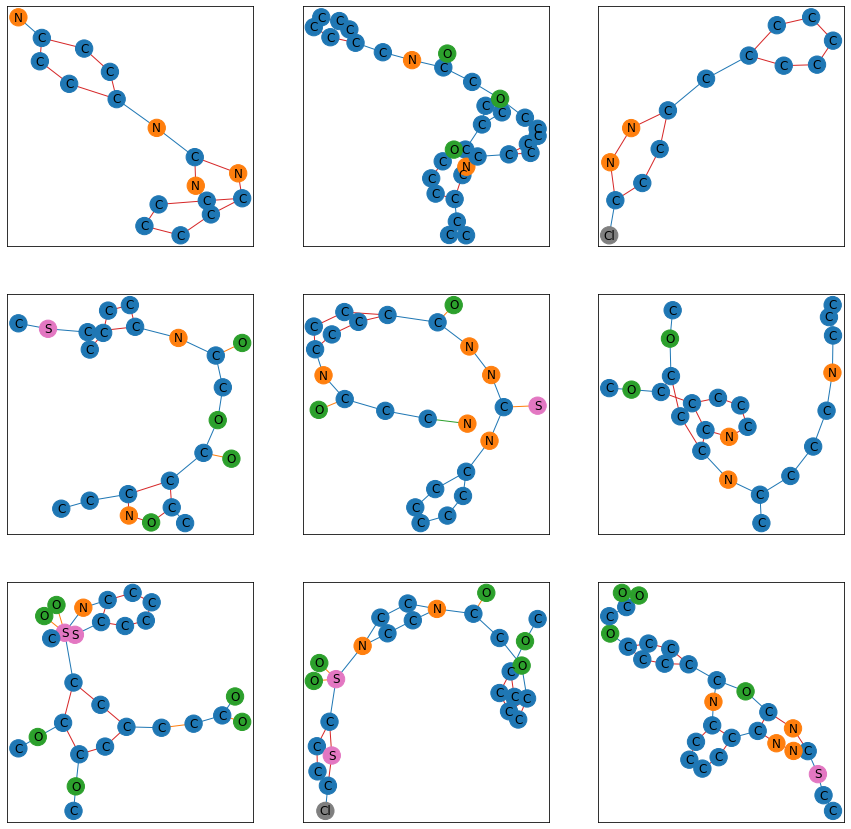

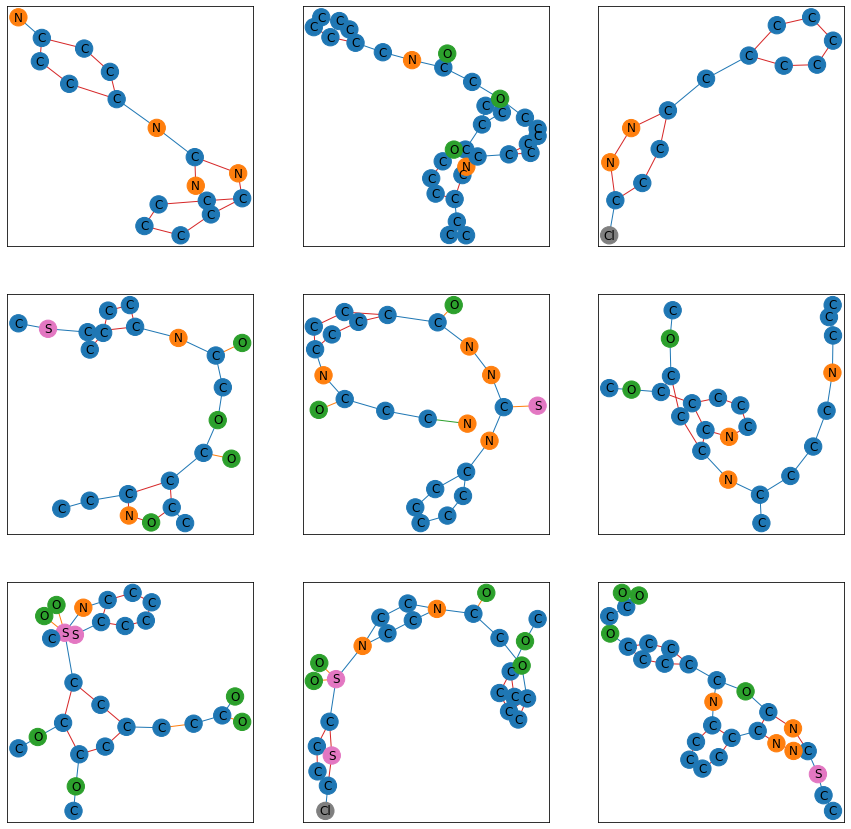

In [8]:
# Visualize examples from training set.
ds, ds_info = tfds.load('ogbg_molpcba', split='train', with_info=True)
tfds.visualization.show_examples(ds, ds_info,
                                 node_color_fn=node_color_fn,
                                 node_label_fn=node_label_fn,
                                 edge_color_fn=edge_color_fn)

## Training

In [ ]:
# Start TensorBoard
# Get a live update during training - use the "refresh" button!
# (In Jupyter[lab] start "tensorboard" in the local directory instead.)
if 'google.colab' in str(get_ipython()):
  %load_ext tensorboard
  %tensorboard --logdir=.

In [10]:
# Training loop
# On Colab CPU, we observed a training speed of 0.2 steps / second.
# On Colab GPU, we observed a training speed of 2.0 steps / second.
# Training is much faster on a GCP machine!

# We don't use TPUs in this Colab because we do not distribute our
# training using pmap() - if you're looking for an example using TPUs
# checkout the below Colab notebook:
# https://colab.research.google.com/github/google/flax/blob/main/examples/imagenet/imagenet.ipynb

config.num_train_steps = 50
state = train.train_and_evaluate(config, workdir=f'./models')

INFO:absl:Starting the local TPU driver.
INFO:absl:Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
INFO:absl:Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.
INFO:absl:Hyperparameters: {'add_self_loops': True, 'add_undirected_edges': True, 'add_virtual_node': False, 'batch_size': 256, 'checkpoint_every_steps': 10000, 'dropout_rate': 0.1, 'eval_every_steps': 1000, 'latent_size': 256, 'layer_norm': True, 'learning_rate': 0.001, 'log_every_steps': 100, 'message_passing_steps': 5, 'model': 'GraphConvNet', 'num_classes': 128, 'num_mlp_layers': 2, 'num_train_steps': 50, 'optimizer': 'adam', 'skip_connections': True}
INFO:absl:Obtaining datasets.
INFO:absl:Load dataset info from /root/tensorflow_datasets/ogbg_molpcba/0.1.2
INFO:absl:Reusing dataset ogbg_molpcba (/root/tensorflow_datasets/ogbg_molpcba/0.1.2)
INFO:absl:Constructing tf.data.Dataset ogbg_molpcba for split train, from /root/tensorflow

In [11]:
#@title Upload to TensorBoard.dev
if 'google.colab' in str(get_ipython()):
  #@markdown You can upload the training results directly to [TensorBoard.dev](https://tensorboard.dev).
  #@markdown
  #@markdown Note that everbody with the link will be able to see the data.
  upload_data = 'no' #@param ['yes', 'no']
  if upload_data == 'yes':
    !tensorboard dev upload --one_shot --logdir ./models --name 'Flax examples/ogbg_molpcba'

## Inference

In [12]:
# Create deterministic evaluation model.
eval_net = train.create_model(config, deterministic=True)
eval_state = state.replace(apply_fn=eval_net.apply)

In [13]:
# Compute accuracy and mean average precision on validation and test sets.
datasets = input_pipeline.get_datasets(
    config.batch_size,
    add_virtual_node=config.add_virtual_node,
    add_undirected_edges=config.add_undirected_edges,
    add_self_loops=config.add_self_loops)
eval_metrics = train.evaluate_model(eval_state, datasets,
                                    splits=['validation', 'test'])

INFO:absl:Load dataset info from /root/tensorflow_datasets/ogbg_molpcba/0.1.2
INFO:absl:Reusing dataset ogbg_molpcba (/root/tensorflow_datasets/ogbg_molpcba/0.1.2)
INFO:absl:Constructing tf.data.Dataset ogbg_molpcba for split train, from /root/tensorflow_datasets/ogbg_molpcba/0.1.2
INFO:absl:Constructing tf.data.Dataset ogbg_molpcba for split validation, from /root/tensorflow_datasets/ogbg_molpcba/0.1.2
INFO:absl:Constructing tf.data.Dataset ogbg_molpcba for split test, from /root/tensorflow_datasets/ogbg_molpcba/0.1.2


In [14]:
for split in ['validation', 'test']:
  split_metrics = eval_metrics[split].compute()
  print(split)
  for metric_name, metric in split_metrics.items():
    print(f'- {metric_name}: {metric:.3f}')

validation
- accuracy: 0.984
- loss: 0.067
- mean_average_precision: 0.027
test
- accuracy: 0.983
- loss: 0.070
- mean_average_precision: 0.028
